#(Train)Multi-filtering Supervised Gene Clustering.

##Current Status:-
Completed.\
_

**Please Run the Dataset Splitter before running this Notebook.** Provide the 
*DATASET_train.csv* generated from the Dataset Splitter Notebook as the 
input to this Notebook at cell 4 as an upload.\
\
*If you already have Gene Representatives from a previous iteration, you can load them and use them here. Loading can be done using the last two cells of this notebook.

In [ ]:
!pip install -U -q PyDrive
!pip install skfeature-chappers

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

import json

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut

from scipy.sparse import *

## Loading the Dataset

In [ ]:
#Uncomment the line below if you have already used the dataset splitter else
#use the original dataset
#files.upload()

# # 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# #2. Get the file
downloaded = drive.CreateFile({'id':'1rS7x4x_DhrUzaBhrgKMQH3uIaLJdPgW3'}) 
# # replace the id with id of file you want to access
# # for Breast - 1enhhyA4u2ByvOjnF81WoHflVNpXtfKpu
# # For Colon - 1AUOto0GhTHW9fX52XSsf9kzYJS5ggv0G
# # For Leukemia- 1xcL-LT-E_gUqWLlqqeVJP1DVHHpiAGe_
# # For Lung - 12KcEVIEZDUEBphMYkDrOPuU-5WFs58ZS
# # for MLL - 1rS7x4x_DhrUzaBhrgKMQH3uIaLJdPgW3
# # for Prostate - 1GjcrHwaS8Gx_BeX3-SA9_Na1CiaVq4r0
# # for Rahc - 1oaOATE0D_f8MGPIMJOMXYVt0hBUWNCKV
# # for Raoa - 1d2vhPcT3I7ZFcAGOQYVLGB3Jx_vEMata
# # for Rbreast - 1Vf-h8zfVP_twMXivcJJtbWtjThShUHvn
# # for SRBCT - 1rO5EEvsoRJl2VVUB3ywKUd3kNiQ24oy3
downloaded.GetContentFile('data.txt')

In [ ]:
#DATASET is the name of the dataset being used.
DATASET="DATA"

#NEIGHBOURS determines neighbours arg for ReliefF
#for any dataset which contains any class sample 
# <10, make it less than 10. Eg of such dataset - SRBCT
NEIGHBOURS = 3 

#p is the number of top genes taken after sorting the filter scores
p=1500

#q is the number of top augmented genes chosen from each filter after running 
#SGC
q = 3
#uncomment the line below if using the dataset splitter else leave it commented 
#data_df = pd.read_csv("%s_train.csv"%(DATASET),index_col=0)

#uncomment the lines below if using the original dataset
dataset = pd.read_table("data.txt",header=None)
data_df = dataset



target = data_df.iloc[:,-1]
feature = pd.DataFrame(data_df.iloc[:,:-1].values,dtype='float')
m,n = feature.shape
print(m,n)
print(feature.head())
print("Number of classes - ")
classes = np.unique(target)
for x in classes:
  print("Class -",x,"Number of Sampples -", len(np.where(target == x)[0]))

feature_norm=pd.DataFrame(MinMaxScaler().fit_transform(feature))

136 12600
   0      1      2      3      4      ...  12595  12596  12597  12598  12599
0   -9.0    1.0    1.0   15.0   -2.0  ...    1.0    0.0   14.0  -23.0   14.0
1   -2.0    1.0    1.0    4.0   -2.0  ...    4.0    5.0    4.0  -10.0   25.0
2   -6.0   17.0    6.0   29.0    4.0  ...    8.0    7.0   21.0  -82.0   10.0
3    0.0    9.0    4.0   19.0  -10.0  ...    3.0   20.0   -7.0  -62.0   24.0
4   -1.0    0.0    1.0    5.0    0.0  ...    3.0    8.0    8.0  -27.0   20.0

[5 rows x 12600 columns]
Number of classes - 
Class - 0 Number of Sampples - 77
Class - 1 Number of Sampples - 59


In [ ]:
#utility function
def plot_feature(feature, target, c = ['r', 'b', 'g', 'y']):
  import matplotlib.pyplot as plt
  from matplotlib import style
  import numpy as np
  style.use('ggplot')
  for idx, each in enumerate(np.unique(target)):
    y = feature[np.where(target == each)[0]]
    x = len(y)
    plt.scatter(range(1, x+1), y, color = c[idx])
    plt.plot(range(1, x+1), y, color = c[idx])

## Creating Filter Methods for Scoring and filtering top rated genes
The Filter Methods chosen for evaluation are:-

1. Mutual Information.
2. ReliefF.
3. Chi Sq.
4. Fisher Score.
5. Signal To Noise Ratio (adapted for multi-class datasets).
6. T-Test.
7. Pearson Corelation Coefficient.

In [ ]:
#construction of ReliefF function

"""
Given a dataset, number of random instances to pick form the dataset and
number of features to consider in each iteration (k), the function returns the weigths of the attributes
of the dataset.
These weigths can then be used as the final results out of the ReliefF algorithm

Paper-

Marko Robnik-ˇSikonja and Igor Kononenko. Theoretical and empirical analysis of relieff
and rrelieff. Machine learning, 53(1-2):23–69, 2003.

"""

def hit_miss_calculator(target,instance,k = 10, hit = True, c = None, ):
    m=len(target)
    upper,lower=instance-1,instance+1
    hits=[]
    hit_flag=False
    #finds k nearest hits
    while(not hit_flag):
      #print(upper,lower)
      if(len(hits)>=k):
        hit_flag = True
        break
      if upper < 0 and lower > m:
        hit_flag = True
        break
      if(upper>=0):
        if((target[upper]==target[instance]) and hit):
          hits.append(upper)
        elif((target[upper]!=target[instance]) and (not hit) and target[upper]==c):
          hits.append(upper)
        upper-=1          
      if(lower<m):
        if((target[lower]==target[instance]) and hit):
          hits.append(lower)
        elif((target[lower]!=target[instance]) and (not hit) and target[lower]==c):
          hits.append(lower)
        lower+=1
    hits.sort()
    return hits


def reliefF(feature,target,k=10,repetitions=10, seed = 0):
  np.random.seed(seed)
  if len(feature.shape)>1:
    m,n=feature.shape
  else:
    m=len(feature)
    n=1
  #print(m,n)
  observations=list(range(m))
  classes=np.unique(target)
  weights=np.zeros(n)
  d=(np.max(feature,axis=0)-np.min(feature,axis=0))*m*k

  for i in range(repetitions):
    instance=np.random.choice(observations,1)[0]
    #print("Iteration",i)
    #print(instance)
    hits=hit_miss_calculator(target,instance,k)
    hit_class_prob=len(np.where(target==target[instance])[0])/m
    #print("\nHit Probability -",hit_class_prob)
    #print("Repetition",i,"Class",target[instance],"Hits -",hits)

    miss={}
    miss_class_prob={}

    for each_class in classes:
      if(each_class != target[instance]):
        miss[each_class]=hit_miss_calculator(target,instance,k,False,each_class)
        class_prob=len(np.where(target==each_class)[0])/m
        #print(each_class,class_prob)
        miss_class_prob[each_class]=hit_class_prob/(1 - (class_prob))

    #print("Repetition",i,"Miss-",miss,"Miss Class Probability -",miss_class_prob)
    
    for hit in hits:
      if len(feature.shape)>1:
        weights-=np.subtract(feature.iloc[instance,:],feature.iloc[hit,:])/d
      else:
        weights-=np.subtract(feature.iloc[instance],feature.iloc[hit])/d
    for each_class in miss:
      for each_miss in miss[each_class]:
        if len(feature.shape)>1:
          weights+=(np.subtract(feature.iloc[instance,:],feature.iloc[each_miss,:])/d)*miss_class_prob[each_class]
        else:
          weights+=(np.subtract(feature.iloc[instance],feature.iloc[each_miss])/d)*miss_class_prob[each_class]
    
    
  return weights.tolist()

In [ ]:
#This function discretizes the given features into 3 categories
def discretize_feature(feature):
  
  mean=np.mean(feature)
  std=np.std(feature)
  discretized=np.copy(feature)
  
  discretized[np.where(feature<(mean+std/2)) ,]=2#within 1/2 std div
  discretized[np.where(feature>(mean-std/2)),]=2#within 1/2 std div
  
  discretized[np.where(feature>(mean+std/2)),]=0#greater than half
  discretized[np.where(feature<(mean-std/2)),]=1#less than half
  
  return discretized

def Xfreq(x):
  xL={}
  for e in x:
    if e not in xL:
      xL[e]=0
    else:
      xL[e]+=1
  for e in xL:
    xL[e]/=len(x)
  return xL

def XYfreq(x,y):
  freq={}
  
  rX=np.unique(x)
  rY=np.unique(y)
      
  for e in rX:
    for f in rY:
      freq[(e,f)]=round(len(np.where(y[np.where(x==e)[0]]==f)[0])/len(x),4)
       
  return freq

def mutual_info(x,y):

  xFreq=Xfreq(x)
  yFreq=Xfreq(y)
  joint=XYfreq(x,y)
  
  Xentropy=0
  for e in xFreq:
    if xFreq[e]!=0:
      Xentropy-=xFreq[e]*np.log2(xFreq[e])
      
  Yentropy=0
  for e in yFreq:
    if yFreq[e]!=0:
      Yentropy-=yFreq[e]*np.log2(yFreq[e])
      
  jentropy=0
  for e in xFreq:
    for f in yFreq:
      if joint[(e,f)]!=0:
        jentropy-=joint[(e,f)]*np.log2(joint[(e,f)])
  
  return (Xentropy+Yentropy-jentropy)

def mutual_info_wrapper(features,target):

  mi=np.array([])
  for x in features:
    discrete=discretize_feature(features[x])
    mi=np.append(mi,mutual_info(discrete,target))
  return np.array(mi)

In [ ]:
"""
This cell is used for defining the method for calculating the t-scores
"""

def t_test(df,target):
  """
  Input:
  df= Dataframe of features (n_samples,n_features)
  target= Pandas Series/1D Numpy Array containing the class labels (n_samples)
  
  Output:
  scores= Descendingly Sorted array of features based on t-test 
  """
  import numpy as np
  from scipy.stats import ttest_ind
  scores=ttest_ind(df[:][target==0],df[:][target==1])[0] #Storing just the t-test scores and discarding the p-values from the result.
  
  # scores=np.argsort(scores,0)
  return [scores] if type(scores) != np.ndarray else scores

  

In [ ]:
from scipy.sparse import *
def fisher_score(X, y):
    import numpy as np
    
    from skfeature.utility.construct_W import construct_W
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels

    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature

    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """

    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)


In [ ]:

#Pearson corelation
def pearson_corr(feature,targetClass):
  import numpy as np
  coef=[np.abs(np.corrcoef(feature[i].values,targetClass)[0,1]) for i in feature.columns]
  # range(feature.shape[1])
  coef=[0 if np.isnan(i) else i for i in coef]
  return coef


In [ ]:
#gini_index 

In [ ]:
#signal to noise ratio
#using weighted one-vs-all strategy for multi-class data
def signaltonoise(feature, target, axis = 0, ddof = 0):
  import numpy as np
  classes = np.unique(target)
  if len(feature.shape)<2:
    feature = feature.reshape(-1,1)
  row, _ = feature.shape
  if len(classes) <= 2:
    m = None
    std = 0
    for each in classes:
      idx = np.where(target == each)[0]
      #convinient way of doing m1-m2
      if m is None:
        m = feature.iloc[idx, :].mean(axis)
      else:
        m -= feature.iloc[idx, :].mean(axis)

      #sd1+sd2
      std += feature.iloc[idx, :].std(axis = axis, ddof = ddof)

    return np.asanyarray(m/std)

  else:
    snr_scores = [] #for storing the weighted scores
    #using the one vs all strategy for each class with
    for each in classes:
      idx = np.where(target == each)[0]
      idxn = np.where(target != each)[0]
      m = feature.iloc[idx, :].mean(axis) - feature.iloc[idxn, :].mean(axis)
      std = feature.iloc[idx, :].std(axis = axis, ddof = ddof) + feature.iloc[idxn, :].std(axis = axis, ddof = ddof) 
      snr_scores.append((m/std) * len(idx)/row) #weighted snr

    return np.asanyarray(snr_scores).sum(axis = axis)

In [ ]:
#intentionally left blank!

In [ ]:
def feature_ranking(score):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

In [ ]:

relief_score=reliefF(feature,target,NEIGHBOURS)

mutual_inf=mutual_info_wrapper(feature,target)

mms=MinMaxScaler()
nfeature=mms.fit_transform(feature)
chi_score,p_val=chi2(nfeature,target)

p_corr = pearson_corr(feature, target)

f_score = fisher_score(feature.values, target)

tt_score = t_test(feature, target)

snr_score = signaltonoise(feature, target)

/usr/local/lib/python3.7/dist-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])
/usr/local/lib/python3.7/dist-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])


In [ ]:
#Can skip this cell
print("Feature Scores (Unsorted)-")
print("ReliefF -",relief_score[:5])
print("Mutual Information -", mutual_inf)
print("Chi Square Test Score -",chi_score)
print("Pearson Corelation - ", p_corr)
print("Fisher Score - ", f_score)
print("T-Test Scores - ", tt_score)
print("Signal to Noise Scores - ", snr_score)

Feature Scores (Unsorted)-
ReliefF - [-0.0015989729225023344, -0.005670539820866616, -0.0007822992210582867, -0.002393110021786493, -6.84402639337387e-05]
Mutual Information - [0.00257779 0.01161106 0.05538952 ... 0.03268346 0.01075761 0.03315475]
Chi Square Test Score - [2.02424109e-02 1.55363991e-01 1.17959768e+00 ... 2.21223795e-01
 2.53570290e-04 6.58976727e-01]
Pearson Corelation -  [0.05836711439442373, 0.12130742425677389, 0.20841478600384283, 0.01062489057253874, 0.2624399338483026, 0.2885457896939379, 0.2681532827619066, 0.2550968381163662, 0.26850811847693296, 0.28216099945247586, 0.2561368084081669, 0.26528354716479574, 0.26303543806660684, 0.07553618787209725, 0.07663187041546256, 0.07221618578118578, 0.05265306510493211, 0.061297628617778106, 0.17839791478045267, 0.12776267410032638, 0.09660447208780745, 0.12197983054078936, 0.1944478226125802, 0.2421477301202624, 0.2416926224892051, 0.24986263439888362, 0.24459625910149244, 0.24848246793156004, 0.23675594811393222, 0.2363

In [ ]:
#The Features are sorted as per their scores
sorted_relief = feature_ranking(relief_score)[:p]
sorted_mi = feature_ranking(mutual_inf)[:p]
sorted_chi = feature_ranking(chi_score)[:p]
sorted_pc = feature_ranking(p_corr)[:p]
sorted_fs = feature_ranking(f_score)[:p]
sorted_tt = feature_ranking(tt_score)[:p]
sorted_snr = feature_ranking(snr_score)[:p]

In [ ]:
#Can Skip this Cell

print("Features after sorting -")
print("\nSorted MI -",sorted_mi)
print("\nSorted Relief -",sorted_relief)
print("\nSorted Chi -",sorted_chi)
print("\nSorted Pearson Corr -",sorted_pc)
print("\nSorted Fisher Score -",sorted_fs)
print("\nSorted T-test -",sorted_tt)
print("\nSorted SNR - ", sorted_snr)

Features after sorting -

Sorted MI - [6184 8849 4364 ... 3078 8651 1578]

Sorted Relief - [  753 12313  6024 ...  3614  6431  2872]

Sorted Chi - [ 6184  8849  6929 ...  7491 10035  3722]

Sorted Pearson Corr - [11199 11051  6184 ...  9706  6863  7712]

Sorted Fisher Score - [11199 11051  6184 ...  9706  6863  7712]

Sorted T-test - [6184 8985 8957 ... 7469 4375 9331]

Sorted SNR -  [6184 8985 4482 ... 5483  435 4928]


## Supervised Gene Clustering
The below cells are used for facilitating the SGC Method of Augmentation

In [ ]:
def score(a,p,target):  
  if p==1:
    return mutual_info_wrapper(pd.DataFrame(a.reshape(-1,1)),target)
    
  if p==2:    
    ndf=pd.DataFrame()
    ndf[0]=a
    reliefa=reliefF(ndf,target,NEIGHBOURS,2)
    return reliefa
  
  if p==3:    
    from sklearn.preprocessing import MinMaxScaler
    mms=MinMaxScaler() 
    a=mms.fit_transform(a.reshape(-1,1))
    chia=chi2(a,target)[0]
    return chia
  
  if p==4:
    return pearson_corr(pd.DataFrame(a.reshape(-1, 1)), target)
  
  if p==5:
    return fisher_score(a.reshape(-1,1), target)
  
  if p==6:
    return t_test(a, target)
  
  if p==7:
    return signaltonoise(pd.DataFrame(a.reshape(-1,1)), target)

In [ ]:
def get_clusters(genes,features,p,target):
  """
  genes - list of subset gene. These are the genes of picked by the score function. Please note that these are just the gene names. Their actual values are passed in the features dataframe
  features - the dataframe which contains the values of the genes
  p - this denotes the  type of score function. 1- mutual information, 2- reliefF, 3- chi square test.
  target - target is a pandas series of target clases for each observation
  """
  clusters={}
  cluster_gene={}
  x,y=0,0
  genes_copy_1=np.copy(genes)
  while(len(genes_copy_1)>0):
    # print("Starting New Iteration with", len(genes_copy_1),"number of genes!")
    genes_copy_2=np.copy(genes_copy_1)
    r_gene=genes_copy_2[0]
    r_gene_values=features[r_gene].values

    clusters[str(r_gene)]=[]
    
    genes_copy_2=np.delete(genes_copy_2,0)
    genes_copy_1=np.delete(genes_copy_1,0)
    
    
    
    r_score=score(r_gene_values,p,target)[0]
    
    # print("\nCluster number=",len(clusters))
    # print("First feature =========================j1=",r_gene,"\n")
    x+=1
    # print("Intial Relevance Score",r_score)

    while(len(genes_copy_2)>0):
      
      gs=genes_copy_2[0]
      gene=features[gs].values

      y+=1      
      
      a_plus=np.add(r_gene_values,gene,dtype='float64') #creating A+
      a_minus=np.subtract(r_gene_values,gene,dtype='float64') #Creating A-

      a_plus_score=score(a_plus,p,target)[0]
      a_minus_score=score(a_minus,p,target)[0]
      
      new_score=a_plus_score if a_plus_score>a_minus_score else a_minus_score
      # print("Gene",gs,"+ Score",a_plus_score,"- Score",a_minus_score)

      if new_score>r_score:

        if a_plus_score==new_score:

          # print("Gene Under Consideration",gs)
          # print("Initial Relevance",r_score,"Final Relevance",a_plus_score,r_score<a_plus_score)

          clusters[str(r_gene)].append(str(gs)+"+")
          r_gene_values=a_plus[:]
          r_score=a_plus_score

          # print("cluster member = +",gs,"\tRelevance Changed to",r_score)

        elif a_minus_score==new_score:

          # print("Gene Under Consideration",gs)
          # print("Initial Relevance",r_score,"Final Relevance",a_minus_score,r_score<a_minus_score)
          
          clusters[str(r_gene)].append(str(gs)+"-")
          r_gene_values=a_minus[:]
          r_score=a_minus_score

        #   print("cluster member = -",gs,"\tRelevance Changed to",r_score)
        # print("Gene",gs,"selected!",np.where(genes_copy_1 == gs))
        genes_copy_1 = np.delete(genes_copy_1, np.where(genes_copy_1 == gs))      
      genes_copy_2=np.delete(genes_copy_2,0)
    
    # for each in clusters[str(r_gene)]:
    #     genes_copy_1=np.delete(genes_copy_1,np.where(genes_copy_1==each))
    cluster_gene[r_gene]=r_gene_values

  #   print("\nFinal Relevance Score",r_score)
  print("Clusters formed! Returning Clusters and Gene Representatives")
  return clusters,cluster_gene

In [ ]:
#Please skip this cell in favour of the next if you are using a local runtime instead of colab.
"""
Computes the clusters via parallel processing

"""
"""
import time
start=time.time()
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())
(mi_cluster,gene_repre_1),(relief_cluster,gene_repre_2),(chi_cluster,gene_repre_3)=[pool.apply(getClusters, args=x) for x in [(sorted_mi,feature,1,target),(sorted_relief,feature,2,target),(sorted_chi,feature,3,target)]]
pool.close()
end=time.time()
print(end-start)
"""

'\nimport time\nstart=time.time()\nimport multiprocessing as mp\npool = mp.Pool(mp.cpu_count())\n(mi_cluster,gene_repre_1),(relief_cluster,gene_repre_2),(chi_cluster,gene_repre_3)=[pool.apply(getClusters, args=x) for x in [(sorted_mi,feature,1,target),(sorted_relief,feature,2,target),(sorted_chi,feature,3,target)]]\npool.close()\nend=time.time()\nprint(end-start)\n'

In [ ]:
mi_cluster, gene_repre_1 = get_clusters(sorted_mi, feature, 1, target)
relief_cluster ,gene_repre_2 = get_clusters(sorted_relief, feature, 2, target)
chi_cluster, gene_repre_3 = get_clusters(sorted_chi, feature, 3, target)

Clusters formed! Returning Clusters and Gene Representatives
Clusters formed! Returning Clusters and Gene Representatives
Clusters formed! Returning Clusters and Gene Representatives


In [ ]:

pc_cluster, gene_repre_4 = get_clusters(sorted_pc, feature, 4, target)
fs_cluster, gene_repre_5 = get_clusters(sorted_fs, feature, 5, target)
tt_cluster, gene_repre_6 = get_clusters(sorted_tt, feature, 6, target)

Clusters formed! Returning Clusters and Gene Representatives


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])
/usr/local/lib/python3.7/dist-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])
/usr/local/lib/python3.7/dist-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = (class_idx

Clusters formed! Returning Clusters and Gene Representatives
Clusters formed! Returning Clusters and Gene Representatives


In [ ]:
snr_cluster, gene_repre_7 = get_clusters(sorted_snr, feature, 7, target)

Clusters formed! Returning Clusters and Gene Representatives


In [ ]:
print("Number of MI Clusters formed -",len(mi_cluster))
print("Number of ReliefF Clusters formed -",len(relief_cluster))
print("Number of ChiSq. Clusters formed -",len(chi_cluster))
print("Number of Pearson Clusters formed -",len(pc_cluster))
print("Number of Fisher Score Clusters formed -",len(fs_cluster))
print("Number of T-Test Clusters formed -",len(tt_cluster))
print("Number of SNR Clusters formed -", len(snr_cluster))

Number of MI Clusters formed - 125
Number of ReliefF Clusters formed - 19
Number of ChiSq. Clusters formed - 39
Number of Pearson Clusters formed - 22
Number of Fisher Score Clusters formed - 22
Number of T-Test Clusters formed - 24
Number of SNR Clusters formed - 31


In [ ]:
qmin = min([len(mi_cluster), len(relief_cluster), len(chi_cluster), len(pc_cluster), len(fs_cluster), len(tt_cluster), len(snr_cluster)])
q = q if q <= qmin else qmin
print("Choosing top %s Augmented Genes from each cluster"%(q))

Choosing top 5 Augmented Genes from each cluster


In [ ]:
gene_repre_1 = pd.DataFrame(gene_repre_1)
gene_repre_2 = pd.DataFrame(gene_repre_2)
gene_repre_3 = pd.DataFrame(gene_repre_3)
gene_repre_4 = pd.DataFrame(gene_repre_4)
gene_repre_5 = pd.DataFrame(gene_repre_5)
gene_repre_6 = pd.DataFrame(gene_repre_6)
gene_repre_7 = pd.DataFrame(gene_repre_7)

In [ ]:
print("MI -",gene_repre_1.head())
print("ReliefF -",gene_repre_2.head())
print("Chi -",gene_repre_3.head())
print("Pearson -",gene_repre_4.head())
print("Fisher Score -",gene_repre_5.head())
print("T-Test -",gene_repre_6.head())
print("SNR -",gene_repre_7.head())

MI -     6184   8849    8057    7065    1218   ...  8466   11216  8798   8542   12258
0  1823.0  595.0   556.0  1576.0  2714.0  ...  -33.0  -12.0   -2.0  -42.0    7.0
1  1297.0  744.0   554.0  1628.0  2779.0  ...  -24.0    8.0   11.0  -30.0   13.0
2   369.0  719.0  1279.0  1292.0  2611.0  ...  -25.0   -1.0   -4.0  -48.0   31.0
3   285.0  155.0   195.0   714.0  1726.0  ...  -23.0  -17.0    7.0  -57.0   28.0
4   377.0  354.0   537.0  1362.0  2339.0  ...  -23.0   11.0   14.0  -44.0   51.0

[5 rows x 125 columns]
ReliefF -    753    6024   11098  1383   12444  ...  8397    10250  12399  12538  491  
0  -48.0  -24.0 -177.0  -78.0  -74.0  ...  602.0  1086.0  485.0  113.0   23.0
1  -34.0  -18.0  -69.0    3.0   18.0  ...  429.0   988.0  513.0  125.0   22.0
2 -167.0 -190.0 -249.0 -226.0  110.0  ...   -7.0  1239.0  189.0  145.0  -47.0
3 -141.0 -218.0 -309.0  -35.0 -190.0  ...  718.0  1724.0  373.0  142.0  -28.0
4  -46.0  -67.0  -46.0  -73.0  -41.0  ...  548.0   459.0  348.0   66.0   16.0

[5 row

## Saving the Gene Representatives and Clusters formed from **SGC**

In [ ]:
#Saving Gene Representatives
gene_repre_1.to_csv("%s_p%s_q%sRepresentative_Genes_1.csv"%(DATASET, p, q),index=False)
gene_repre_2.to_csv("%s_p%s_q%sRepresentative_Genes_2.csv"%(DATASET, p, q),index=False)
gene_repre_3.to_csv("%s_p%s_q%sRepresentative_Genes_3.csv"%(DATASET, p, q),index=False)
gene_repre_4.to_csv("%s_p%s_q%sRepresentative_Genes_4.csv"%(DATASET, p, q),index=False)
gene_repre_5.to_csv("%s_p%s_q%sRepresentative_Genes_5.csv"%(DATASET, p, q),index=False)
gene_repre_6.to_csv("%s_p%s_q%sRepresentative_Genes_6.csv"%(DATASET, p, q),index=False)
gene_repre_7.to_csv("%s_p%s_q%sRepresentative_Genes_7.csv"%(DATASET, p, q),index=False)

In [ ]:
"""
Saving the clusters to JSON files, this preserves the gene selection sequence
"""
with open('%s_p%s_q%smi_cluster.json'%(DATASET, p, q), 'w') as fp:
    json.dump(mi_cluster, fp)

with open('%s_p%s_q%srelief_cluster.json'%(DATASET, p, q), 'w') as fp:
    json.dump(relief_cluster, fp)


with open('%s_p%s_q%schi_cluster.json'%(DATASET, p, q), 'w') as fp:
    json.dump(chi_cluster, fp)

with open('%s_p%s_q%spc_cluster.json'%(DATASET, p, q), 'w') as fp:
    json.dump(pc_cluster, fp)

with open('%s_p%s_q%sfs_cluster.json'%(DATASET, p, q), 'w') as fp:
    json.dump(fs_cluster, fp)

with open('%s_p%s_q%stt_cluster.json'%(DATASET, p, q), 'w') as fp:
    json.dump(tt_cluster, fp)

with open('%s_p%s_q%ssnr_cluster.json'%(DATASET, p, q), 'w') as fp:
    json.dump(snr_cluster, fp)

In [ ]:
def sort_keys(scores,gene_repre,target,flag=True):
  score_dict={}
  x=0
  for i in gene_repre.columns:
    score_dict[i]=scores[x]
    x+=1
  return [k for k, v in sorted(score_dict.items(), key=lambda item: item[1], reverse = True)]

In [ ]:
"""
feature_ranking cannot be used here because it sorts and returns the indices from 0-1
They need to be sorted using a different function
"""
sorted_mi_keys=sort_keys(mutual_info_wrapper(gene_repre_1,target),gene_repre_1,target,True)[:q]

sorted_relief_keys=sort_keys(reliefF(gene_repre_2,target,k=NEIGHBOURS,repetitions=5),gene_repre_2,target,True)[:q]

mms=MinMaxScaler()
nfeature=mms.fit_transform(gene_repre_3)
chi_score,p_val=chi2(nfeature,target)
sorted_chi_keys=sort_keys(chi_score,gene_repre_3,target,False)[:q]

sorted_pc_keys=sort_keys(pearson_corr(gene_repre_4,target),gene_repre_4,target,True)[:q]

sorted_fs_keys=sort_keys(fisher_score(gene_repre_5.values,target),gene_repre_5,target,True)[:q]

sorted_tt_keys=sort_keys(t_test(gene_repre_6,target),gene_repre_6,target,True)[:q]

sorted_snr_keys = sort_keys(signaltonoise(gene_repre_7, target), gene_repre_7, target, True)[:q]

/usr/local/lib/python3.7/dist-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])
/usr/local/lib/python3.7/dist-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])


In [ ]:
print("MI cluster after sorting - ",sorted_mi_keys)
print("Relief cluster after sorting - ",sorted_relief_keys)
print("Chi cluster after sorting - ",sorted_chi_keys)
print("Pearson cluster after sorting - ",sorted_pc_keys)
print("Fisher cluster after sorting - ",sorted_fs_keys)
print("T-Test cluster after sorting - ",sorted_tt_keys)
print("SNR cluster after sorting - ",sorted_snr_keys)

MI cluster after sorting -  [6184, 8849, 3935, 1218, 7883]
Relief cluster after sorting -  [5286, 753, 3713, 1151, 10250]
Chi cluster after sorting -  [6929, 6184, 8497, 8650, 8451]
Pearson cluster after sorting -  [11199, 8057, 8957, 8849, 12019]
Fisher cluster after sorting -  [11199, 8057, 8957, 8849, 12019]
T-Test cluster after sorting -  [6184, 8057, 8849, 12019, 7393]
SNR cluster after sorting -  [6184, 4482, 8057, 8849, 4364]


## Testing Classification of the Augmented Genes.
Here the classfication accuracy is tested using **KNN, Decision Tree, Naive Bayes** and **SVM** as well as the **Ensemble** of them.\
\
Top i (where i ranges from 1 to q) are chosen from each augmented dataset of filters and a new dataset is created using these augmented genes. This dataset is used for classification.

In [ ]:
LOOCV=LeaveOneOut()
data_KNN = KNeighborsClassifier(n_neighbors= int(feature.shape[0] ** 0.5))
data_SVM = SVC(kernel='rbf',gamma='scale')
data_NB = GaussianNB()
data_Tree = DecisionTreeClassifier()
rows = feature.shape[0]

classifiers=["NB","KNN","Tree","SVM"]
classifier_dict = { "NB": GaussianNB(), 
                   "KNN": KNeighborsClassifier(n_neighbors= int(feature.shape[0] ** 0.5)), 
                   "Tree": DecisionTreeClassifier(), 
                   "SVM": SVC(kernel='rbf',gamma='scale')}

"""

"""

keys_list={"MI":sorted_mi_keys, "ReliefF":sorted_relief_keys, 
           "Chi":sorted_chi_keys,  
           "Fisher":sorted_fs_keys, "Pearson":sorted_pc_keys, "tTest":sorted_tt_keys, 
           "SNR":sorted_snr_keys}
"""
   
"""
cluster_list={"MI":gene_repre_1, "ReliefF":gene_repre_2,
              "Chi":gene_repre_3, "Pearson":gene_repre_4, 
              "Fisher":gene_repre_5,"tTest":gene_repre_6, 
              "SNR":gene_repre_7}

In [ ]:
#balacing of dataset
def balance(df,r=True) :
    s=df.shape[0]
    df=df.sort_values('l')
    df=df.reset_index(drop=True)
    k=0
    for i in df['l'][:] :
        if i==1 :
            break
        k=k+1
    df1=df[:][:k]
    df2=df[:][k:]
    if df1.shape[0]<df2.shape[0] :
        l=s-(k*2)
        df3=df1.sample(n=l,replace=r)
    else :
        l=(k*2)-s
        df3=df2.sample(n=l,replace=r)
    frame=[df1,df2,df3]
    result=pd.concat(frame)
    df4=result.reset_index(drop=True)
    return df4


In [ ]:
acc_matrix = pd.DataFrame()
for i in range(1,q+1):
  """
  Make a dataframe out of i keys from each gene_representatives from their 
  respective sorted keys. 
  Than use LOOCV to measure accuracy on Train Dataset.
  """
  cluster_df=pd.DataFrame()
  s=0
  for filter_name in keys_list:
    tem_df = cluster_list[filter_name][keys_list[filter_name][:i]]
    for x in range(i):
      cluster_df[s] = tem_df.iloc[:, x]
      s += 1
  # print(cluster_df.shape)
  acc=0
  individual_acc = np.zeros(4)
  
  for train_index,test_index in LOOCV.split(cluster_df):
    """
    Data is divided into train-test splits and then polling method is used 
    to find the classification results (ensemble of KNN,SVM,NB,Decision Tree)
    """
    train_data,train_labels=cluster_df.iloc[train_index,:],target[train_index]
    test_data,test_labels=cluster_df.iloc[test_index,:],target[test_index].values.tolist()[0]
    data_KNN.fit(train_data,train_labels)
    data_SVM.fit(train_data,train_labels)
    data_NB.fit(train_data,train_labels)
    data_Tree.fit(train_data,train_labels)

    class_list = [data_NB, data_KNN, data_Tree, data_SVM]
    results=[]
    for x in range(4):
      tem_result = class_list[x].predict(test_data)[0]
      if tem_result == test_labels:
        individual_acc[x]+=1
      results.append(tem_result)
    polling_result=0
    max_freq=0
    for x in results:
      freq=results.count(x)
      if freq>max_freq:
        max_freq=freq
        polling_result=x
    if polling_result == test_labels:
      acc+=1
  individual_acc = np.round(individual_acc/cluster_df.shape[0],4)
  individual_acc = np.append(individual_acc, np.round(acc/cluster_df.shape[0],4))
  # print(individual_acc)
  acc_matrix[i] = individual_acc
acc_matrix = acc_matrix.T
acc_matrix.columns = classifiers[:]+['Ensemble']
print(acc_matrix)
acc_matrix.to_csv("Train-Multi-SGC-%s_p%s_q%s_Accuracy_Matrix.csv"%(DATASET, p, q))

       NB     KNN    Tree     SVM  Ensemble
1  0.9412  0.9485  0.9559  0.9485    0.9706
2  0.9559  0.9559  0.9412  0.9706    0.9706
3  0.9632  0.9559  0.9265  0.9485    0.9485
4  0.9559  0.9779  0.9412  0.9706    0.9632
5  0.9559  0.9779  0.9412  0.9559    0.9706


## MFSGC-EC Bootstrap

In [ ]:
#vars
bootno=5
samplevalue=130

In [ ]:
acc_df = []
for i in range(1, q+1):  
  #Ensemble of same type classifiers for each filter

  #records the ensemble classifier accuracy of each classifier with i genes
  classifier_accuracy = [] 

  for each_classifier in classifier_dict:
    
    #records the accuracy of the current classifier
    acc=0
    for train_index, test_index in LOOCV.split(range(rows)):
      """
      Data is divided into train-test splits and then polling method is used 
      to find the classification results (ensemble of KNN,SVM,NB,Decision Tree)
      """
      
      filter_result = []
      for filter_name in keys_list:
        for k in range(bootno):

        #taking the train-test split from each filter
            train_data,train_labels = cluster_list[filter_name].iloc[train_index,:i],target[train_index]
            test_data,test_labels = cluster_list[filter_name].iloc[test_index,:i],target[test_index].values.tolist()[0]
            tmp_data=train_data.copy()
            tmp_data['l']=train_labels.copy()
            tmp_data=balance(tmp_data.copy())
            tmp_data=tmp_data.sample(n=samplevalue,replace=True)
            tmp_data=tmp_data.reset_index(drop=True)
            tmp_target=tmp_data['l']
            tmp_data=tmp_data.drop(columns="l")
            #print(tmp_data,tmp_target,train_data,train_labels)

        #filter wise fit and predict from the same type of classifier
            classifier_dict[each_classifier].fit(tmp_data, tmp_target)
            filter_result.append(classifier_dict[each_classifier].predict(test_data)[0])
      #generating the polling result of all filters' classifiers
      polling_result = None
      max_freq = 0
      for each in set(filter_result):
        freq = filter_result.count(each)
        if freq>max_freq:
          max_freq = freq
          polling_result = each

      if polling_result == test_labels:
        acc+=1
    
    acc = np.round(acc/rows,4)
    classifier_accuracy.append(acc)

  #records the ensemble classifier accuracy from 1 to q genes for each classifier
  acc_df.append(classifier_accuracy)    
acc_df = pd.DataFrame(acc_df, columns= classifier_dict.keys())
acc_df.to_csv("Train-EC-Multi-SGC-%s_p%s_q%s_Accuracy_Matrix.csv"%(DATASET, p, q))
print(acc_df)

       NB     KNN    Tree     SVM
0  0.9632  0.9779  0.9779  0.9559
1  0.9779  0.9779  0.9779  0.9706
2  0.9779  0.9706  0.9779  0.9779
3  0.9853  0.9926  0.9779  0.9926
4  0.9853  0.9779  0.9706  0.9779


## 10-fold Cross Validation Bootstrap

In [ ]:
#vars
bootno=5
samplevalue=130

In [ ]:
def calculate_roc(actual_labels, poll_results,name):
  import numpy as np
  from sklearn import metrics
  import matplotlib.pyplot as plt
  
  fpr, tpr, thresholds = metrics.roc_curve(actual_labels, poll_results)
  metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2)
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.title(label='ROC curve, Area %s'%(str(metrics.auc(fpr, tpr))))
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  print(name)
  plt.savefig(name)
  plt.show()

def plot_confusion_matrix(confusion_matrix, DATASET, each_classifier, i, name = "LOOCV"):
  import seaborn as sn
  import pandas as pd
  import matplotlib.pyplot as plt
  
  plt.figure(figsize = confusion_matrix.shape)
  hm = sn.heatmap(confusion_matrix, annot=True)
  hm.get_figure().savefig("%s_confusion_matrix_heatmap_%s_%s_%s.png"%(name, DATASET, each_classifier, i))

In [ ]:
from sklearn.model_selection import KFold

kfcv = KFold(10, True, random_state = 0)

10FCV_confusion_matrix_roc_Breast_NB_1.png


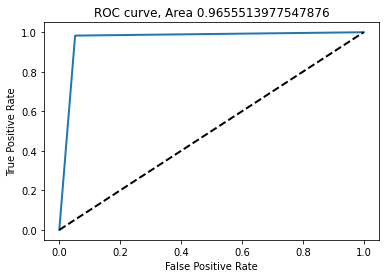

10FCV_confusion_matrix_roc_Breast_KNN_1.png


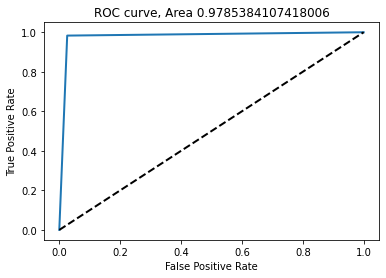

10FCV_confusion_matrix_roc_Breast_Tree_1.png


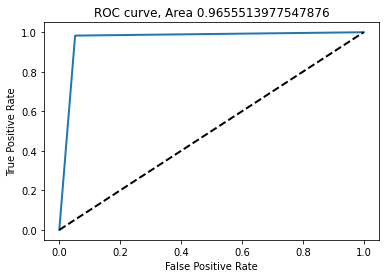

10FCV_confusion_matrix_roc_Breast_SVM_1.png


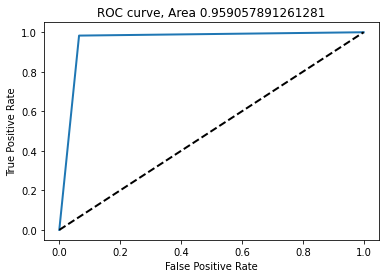

10FCV_confusion_matrix_roc_Breast_NB_2.png


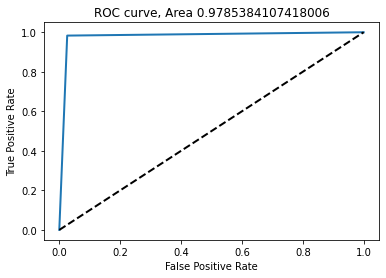

10FCV_confusion_matrix_roc_Breast_KNN_2.png


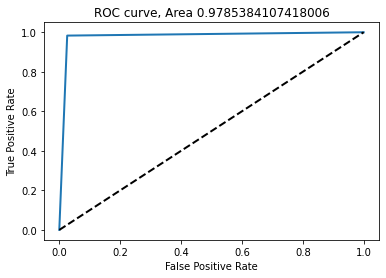

10FCV_confusion_matrix_roc_Breast_Tree_2.png


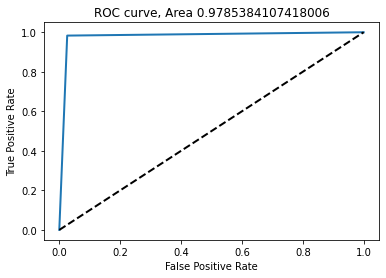

10FCV_confusion_matrix_roc_Breast_SVM_2.png


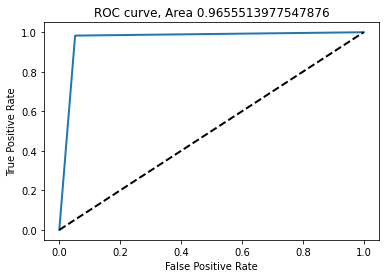

10FCV_confusion_matrix_roc_Breast_NB_3.png


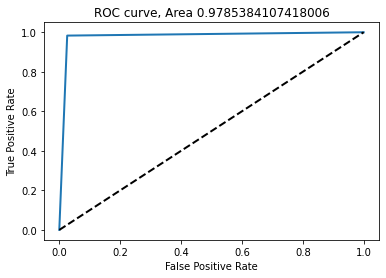

10FCV_confusion_matrix_roc_Breast_KNN_3.png


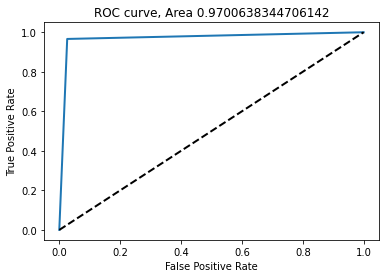

10FCV_confusion_matrix_roc_Breast_Tree_3.png


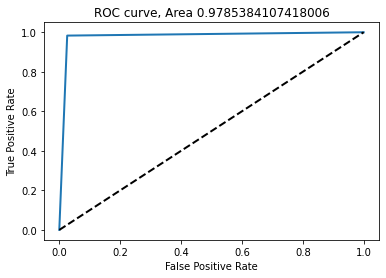

10FCV_confusion_matrix_roc_Breast_SVM_3.png


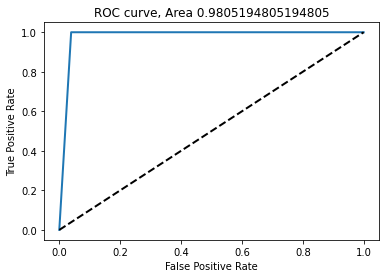

10FCV_confusion_matrix_roc_Breast_NB_4.png


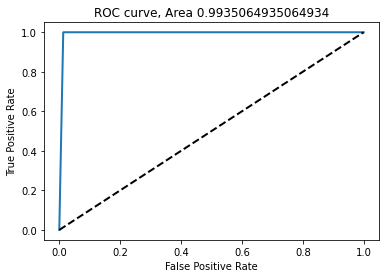

10FCV_confusion_matrix_roc_Breast_KNN_4.png


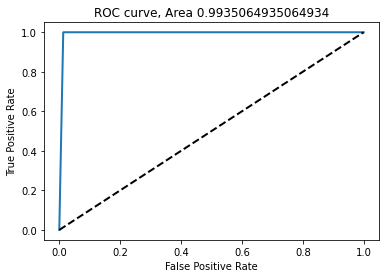

10FCV_confusion_matrix_roc_Breast_Tree_4.png


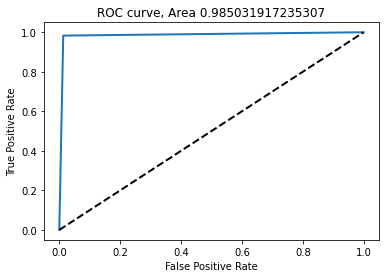

10FCV_confusion_matrix_roc_Breast_SVM_4.png


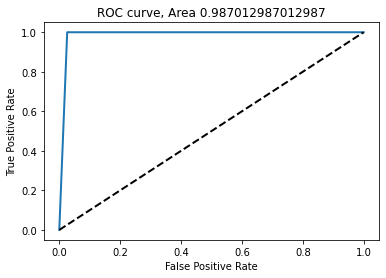

10FCV_confusion_matrix_roc_Breast_NB_5.png


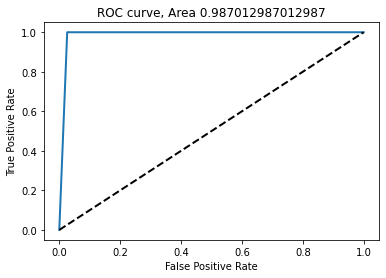

10FCV_confusion_matrix_roc_Breast_KNN_5.png


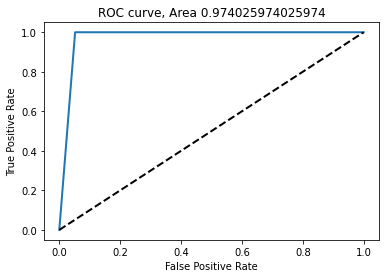

10FCV_confusion_matrix_roc_Breast_Tree_5.png


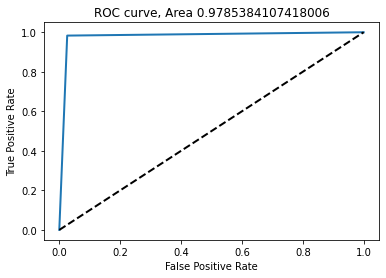

10FCV_confusion_matrix_roc_Breast_SVM_5.png


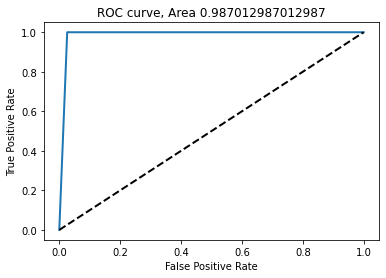

       NB     KNN    Tree     SVM
0  0.9632  0.9779  0.9632  0.9559
1  0.9779  0.9779  0.9779  0.9632
2  0.9779  0.9706  0.9779  0.9779
3  0.9926  0.9926  0.9853  0.9853
4  0.9853  0.9706  0.9779  0.9853


In [ ]:
if len(classes) > 2:
  flag = True
else:
  flag = False

acc_df = []
for i in range(1, q+1):  
  #Ensemble of same type classifiers for each filter

  #records the ensemble classifier accuracy of each classifier with i genes
  classifier_accuracy = [] 

  for each_classifier in classifier_dict:
    #creating confusion matrix.
    confusion_matrix = np.zeros(classes.shape[0]**2).reshape(classes.shape[0], classes.shape[0])
    #records the accuracy of the current classifier
    acc=0
    poll_results = []
    actual_labels = []
    for train_index, test_index in kfcv.split(range(rows)):
      """
      Data is divided into train-test splits and then polling method is used 
      to find the classification results (ensemble of KNN,SVM,NB,Decision Tree)
      """
      #print(train_index,test_index)
      filter_result = np.zeros((len(keys_list)*bootno, len(test_index)))
      #print(filter_result.shape)
      for idx1, filter_name in enumerate(keys_list):
        for k in range(bootno):
          #print(idx1,filter_name)
          #taking the train-test split from each filter
          train_data,train_labels = cluster_list[filter_name].iloc[train_index,:i],target[train_index]
          test_data,test_labels = cluster_list[filter_name].iloc[test_index,:i].values,target[test_index].values
          tmp_data=train_data.copy()
          tmp_data['l']=train_labels.copy()
          tmp_data=balance(tmp_data.copy(),r=True)
          tmp_data=tmp_data.sample(n=samplevalue,replace=True)
          tmp_data=tmp_data.reset_index(drop=True)
          tmp_target=tmp_data['l']
          tmp_data=tmp_data.drop(columns="l")
          # print("Test Label",test_labels)
          #filter wise fit and predict from the same type of classifier
          classifier_dict[each_classifier].fit(tmp_data, tmp_target)
          for idx2, tst_data in enumerate(test_data):
            # print(idx2,tst_data)
            filter_result[(idx1*bootno)+k, idx2] = classifier_dict[each_classifier].predict(tst_data.reshape(1,-1))[0]
            #print(filter_result)

      #generating the polling result of all filters' classifiers
      for each_col in range(filter_result.shape[1]):

        polling_result = None
        max_freq = 0
        data_col = filter_result[:,each_col]
        for each in set(data_col):
          freq = data_col.tolist().count(each)
          if freq>max_freq:
            max_freq = freq
            polling_result = each
        # print(polling_result)
        poll_results.append(polling_result)
        actual_labels.append(test_labels[each_col])
        confusion_matrix[int(polling_result), int(test_labels[each_col])] += 1
        if polling_result == test_labels[each_col]:
          acc+=1
    
    acc = np.round(acc/rows,4)
    classifier_accuracy.append(acc)
    # print("Confusion Matrix for %s with %s genes:-\n"%(each_classifier, i), confusion_matrix)
    confusion_matrix = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
    confusion_matrix.to_csv("10FCV_confusion_matrix_%s_%s_%s.csv"%(DATASET, each_classifier, i))
    if flag:
      plot_confusion_matrix(confusion_matrix, DATASET, each_classifier, i, "10FCV")
    else:
      calculate_roc(actual_labels, poll_results, "10FCV_confusion_matrix_roc_%s_%s_%s.png"%(DATASET, each_classifier, i) )

  #records the ensemble classifier accuracy from 1 to q genes for each classifier
  acc_df.append(classifier_accuracy)    
acc_df = pd.DataFrame(acc_df, columns= classifier_dict.keys())
acc_df.to_csv("10FCV-Train-EC-Multi-SGC-%s_p%s_q%s_Accuracy_Matrix.csv"%(DATASET, p, q))
print(acc_df)